In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_rows=2000
pd.options.display.max_columns=500

In [2]:
df = pd.read_csv('melbourne_listings.csv',low_memory=False)
df.shape

(25741, 106)

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,20200215012707,2020-02-15,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",none,Very safe! Family oriented. Older age group.,NaN,"YES ! The bus (305,309) is exactly two blocks ...","Kitchen, backyard, upstairs lounge. We'd like ...",As much as the guest wants.,Prefence would be given females or a couple,NaN,NaN,https://a0.muscache.com/im/pictures/44620/5a58...,NaN,33057,https://www.airbnb.com/users/show/33057,Manju,2009-08-21,AU,About us: We are an East Indian couple in our ...,a few days or more,0%,0%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",f,f,"Bulleen, VIC, Australia",Balwyn North,Manningham,NaN,Bulleen,VIC,3105,Melbourne,"Bulleen, Australia",AU,Australia,-37.77268,145.09213,f,House,Private room,2,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Do...",NaN,$60.00,NaN,NaN,NaN,NaN,1,$22.00,1,365,1,1,365,365,1.0,365.0,31 months ago,t,30,60,90,365,2020-02-15,4,0,2011-05-24,2015-09-12,90.0,9.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.04
1,10803,https://www.airbnb.com/rooms/10803,20200215012707,2020-02-15,Room in Cool Deco Apartment in Brunswick East,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,none,This hip area is a crossroads between two grea...,Due to Airbnb policies I don’t accept bookings...,Easy transport options - the tram is right out...,Wifi. Bathroom and kitchen is shared but I mos...,I'm home mostly but sometimes I may be working...,Theres a yoga studio downstairs so if you see ...,NaN,NaN,https://a0.muscache.com/im/pictures/31323790/9...,NaN,38901,https://www.airbnb.com/users/show/38901,Lindsay,2009-09-16,"Melbourne, Victoria, Australia",As an artist working in animation and video I ...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/38901/profile...,https://a0.muscache.com/im/users/38901/profile...,Brunswick,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Brunswick East, VIC, Australia",Brunswick,More

In [4]:
def clean_price(price_series):
     return pd.to_numeric(price_series.str.replace("$","").str.replace(",",""))

def bin_price(price_series_cleaned):
    
    bins = [0,100,200,300,400,50000]

    labels = ['$0-99',
            '$100-199',
            '$200-299',
            '$300-399',
            'More than $400']
    
    return pd.cut(price_series_cleaned, bins, labels=labels)


def is_cbd(neighbourhood_cleansed_series, city):
    return neighbourhood_cleansed_series.apply(lambda row: 1 if row == city else 0)


def area(is_cbd_series, city):
    return is_cbd_series.map({0: 'Suburbs', 1: 'City Area'})


def clean_property(property_df, property_feature):

    apartment_property = property_df[property_feature].isin(['Apartment','Condominium'])
    property_df.loc[apartment_property,property_feature] = 'Apartment'
    
    house_property = property_df[property_feature].isin(['House','Townhouse','Cottage','Villa'])
    property_df.loc[house_property,property_feature] = 'House/Townhouse'
    
    other_property = ~property_df[property_df[property_feature].notnull()][property_feature].isin(['Apartment','House/Townhouse'])
    property_df.loc[other_property,property_feature] = 'Others'

In [5]:
df['price'] = clean_price(df['price'])
df['price_range'] = bin_price(df['price'])
df['is_cbd'] = is_cbd(df['neighbourhood_cleansed'], 'Melbourne')
df['area'] = area(df['is_cbd'], 'Melbourne')
df['state_city'] = 'Melbourne'

cbd = df[df['is_cbd'] == 1]
not_cbd = df[df['is_cbd'] == 0]

clean_property(df,'property_type')

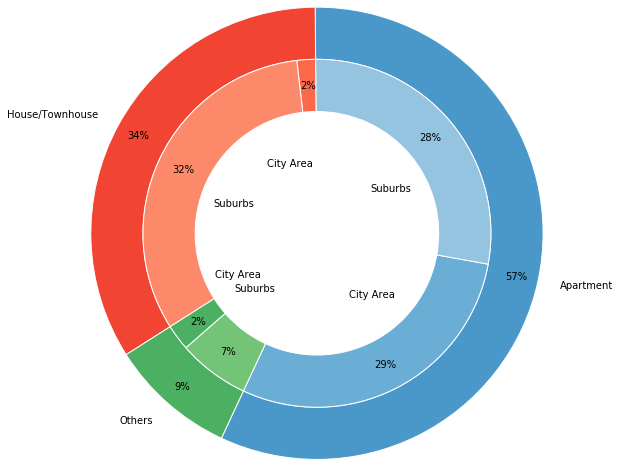

In [6]:
# outer circle
outer_label = ['Apartment','House/Townhouse','Others']
outer = df['property_type'].value_counts(normalize=True).values

# inner circle
inner_label = ['City Area','Suburbs','City Area','Suburbs','City Area','Suburbs']
inner = df.groupby(['property_type'])['area'].value_counts(normalize=True).sort_index()

inner = [outer[0]*inner[0],
         outer[0]*inner[1],
         outer[1]*inner[2],
         outer[1]*inner[3],
         outer[2]*inner[4],
         outer[2]*inner[5]]

size=0.3
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]

fig, ax = plt.subplots(figsize=[10,8])
ax.axis('equal')
ax.pie(outer, radius=1.3, labels=outer_label,wedgeprops=dict(width=size, edgecolor='w'),colors= [a(0.6), b(0.6), c(0.6)],startangle=-115,autopct='%.f%%',pctdistance=0.9)
ax.pie(inner, radius=1.3-0.3, labels=inner_label,labeldistance=0.4, wedgeprops=dict(width=size, edgecolor='w'), colors=[a(0.5), a(0.4), b(0.5), b(0.4), c(0.6), c(0.5)],startangle=-115,autopct='%.f%%',pctdistance=0.85);

plt.savefig('1.png')

## Is the price in the cbd more expensive than non-cbd?

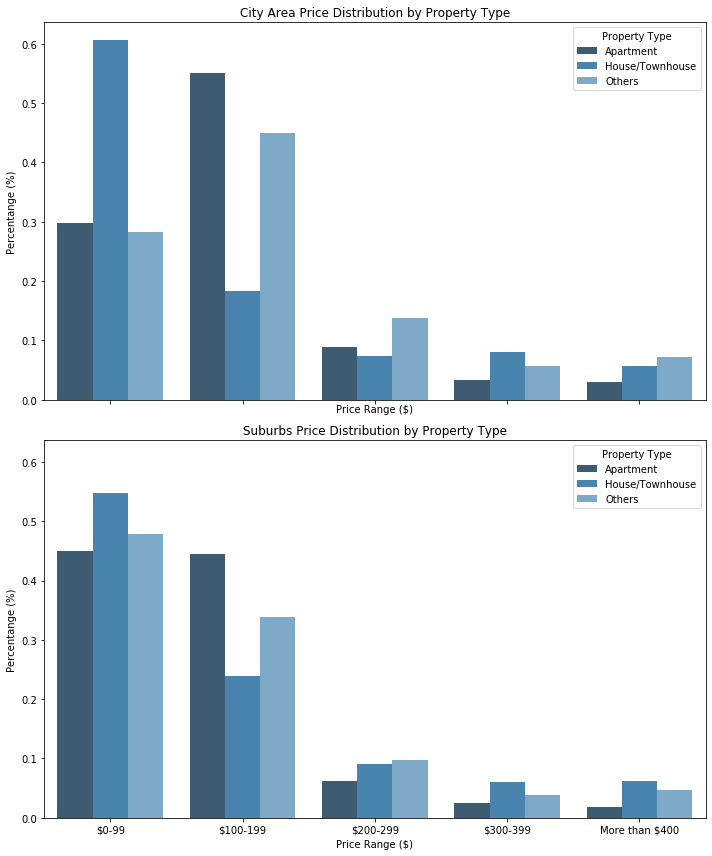

In [7]:
agg = df.groupby(['area','property_type'])['price_range'].value_counts(normalize=True).sort_index().rename('prop').reset_index()
city_agg = agg[agg['area'] == 'City Area']
suburb_agg = agg[agg['area'] == 'Suburbs']

agg_df = [city_agg,suburb_agg]
agg_title = ['City Area Price Distribution by Property Type','Suburbs Price Distribution by Property Type']

fig, ax = plt.subplots(2,1,figsize=[10,12],sharey=True,sharex=True)

for i, df_agg in enumerate(agg_df):
        
    sns.barplot(data=df_agg,x='price_range',y='prop',hue='property_type',palette='Blues_d',ax=ax[i])
    
    ax[i].set_xlabel('Price Range ($)')
    ax[i].set_title(agg_title[i])
    ax[i].set_ylabel('Percentange (%)')
    #ax[i].grid(True)
    ax[i].legend().set_title('Property Type')
    
plt.tight_layout()    
plt.savefig('2.png')

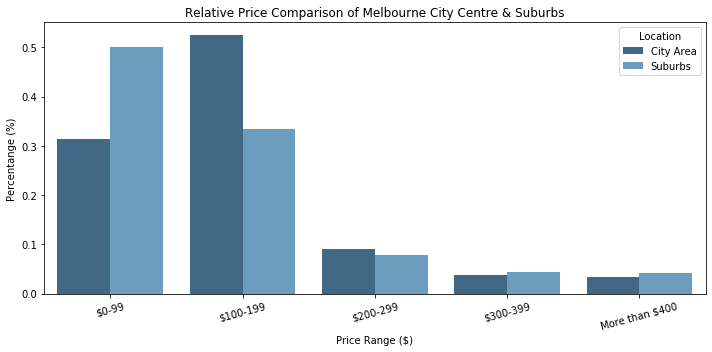

In [8]:
sub = df.groupby('area')['price_range'].value_counts(normalize=True).rename('val').sort_index().reset_index()

plt.figure(figsize=[10,5])
sns.barplot(data=sub,x='price_range',y='val',hue='area',palette='Blues_d')
plt.xticks(rotation=15)
plt.xlabel('Price Range ($)')
plt.ylabel('Percentange (%)')
plt.title('Relative Price Comparison of Melbourne City Centre & Suburbs')
#plt.grid(True)
plt.legend(title='Location')

plt.tight_layout()
plt.savefig('3.png');

# Price comparison between major australian cities

In [9]:
#=================================== Sydney ===================================#
syd_df = pd.read_csv('sydney_listings.csv',low_memory=False)

syd_df['price'] = clean_price(syd_df['price'])
syd_df['price_range'] = bin_price(syd_df['price'])
syd_df['is_cbd'] = is_cbd(syd_df['neighbourhood_cleansed'], 'Sydney')
syd_df['area'] = area(syd_df['is_cbd'], 'Sydney')
syd_df['state_city'] = 'Sydney'

#=================================== Perth ===================================#
perth_df = pd.read_csv('wa_listings.csv',low_memory=False)
perth_df['price'] = clean_price(perth_df['price'])
perth_df['price_range'] = bin_price(perth_df['price'])
perth_df['is_cbd'] =  is_cbd(perth_df['neighbourhood_cleansed'],'PERTH')
perth_df['area'] = area(perth_df['is_cbd'], 'Perth')
perth_df['state_city'] = 'Perth'

#================================= Tasmania =================================#
tas_df = pd.read_csv('tas_listings.csv',low_memory=False)
tas_df['price'] = clean_price(tas_df['price'])
tas_df['price_range'] = bin_price(tas_df['price'])
tas_df['is_cbd'] =  is_cbd(tas_df['neighbourhood_cleansed'],'Hobart')
tas_df['area'] = area(tas_df['is_cbd'], 'Hobart')
tas_df['state_city'] = 'Hobart'


In [10]:
comb_df = pd.concat([df,syd_df,tas_df,perth_df],ignore_index=True)
comb_df.shape

(84958, 110)

In [11]:
comb_df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_range,is_cbd,area,state_city
0,9835,https://www.airbnb.com/rooms/9835,20200215012707,2020-02-15,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",none,Very safe! Family oriented. Older age group.,NaN,"YES ! The bus (305,309) is exactly two blocks ...","Kitchen, backyard, upstairs lounge. We'd like ...",As much as the guest wants.,Prefence would be given females or a couple,NaN,NaN,https://a0.muscache.com/im/pictures/44620/5a58...,NaN,33057,https://www.airbnb.com/users/show/33057,Manju,2009-08-21,AU,About us: We are an East Indian couple in our ...,a few days or more,0%,0%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",f,f,"Bulleen, VIC, Australia",Balwyn North,Manningham,NaN,Bulleen,VIC,3105,Melbourne,"Bulleen, Australia",AU,Australia,-37.77268,145.09213,f,House/Townhouse,Private room,2,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Do...",NaN,60.0,NaN,NaN,NaN,NaN,1,$22.00,1,365,1,1,365,365,1.0,365.0,31 months ago,t,30,60,90,365,2020-02-15,4,0,2011-05-24,2015-09-12,90.0,9.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.04,$0-99,0,Suburbs,Melbourne


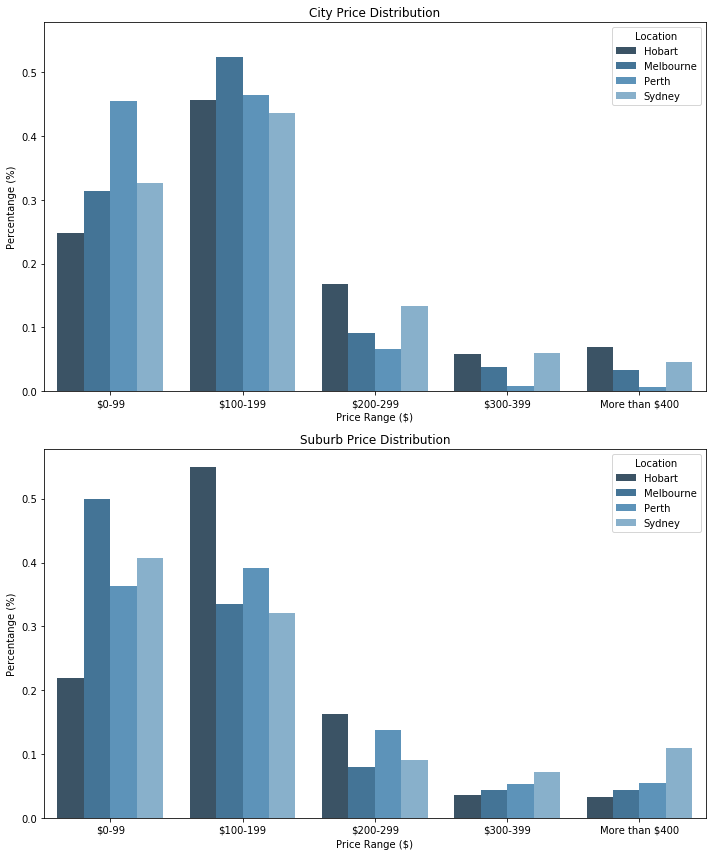

In [12]:
comb_cbd = comb_df[comb_df['is_cbd'] == 1]
comb_not_cbd = comb_df[comb_df['is_cbd'] == 0]

agg_comb_cbd = comb_cbd.groupby(['state_city'])['price_range'].value_counts(normalize=True).sort_index().rename('value').reset_index()
agg_comb_not_cbd = comb_not_cbd.groupby(['state_city'])['price_range'].value_counts(normalize=True).sort_index().rename('value').reset_index()

avg_df = [agg_comb_cbd, agg_comb_not_cbd]
title = ['City Price Distribution','Suburb Price Distribution']
    
fig, ax = plt.subplots(2,1,figsize=[10,12], sharey=True)

for i, a in enumerate(avg_df):
    
    axes=ax[i]
    sns.barplot(data=a,x='price_range',y='value',hue='state_city',palette='Blues_d',ax=axes)
    axes.title.set_text(title[i])
    axes.set_xlabel('Price Range ($)')
    axes.set_ylabel('Percentange (%)')
    axes.legend().set_title('Location')

plt.tight_layout()
plt.savefig('4.png')

# Conclusion

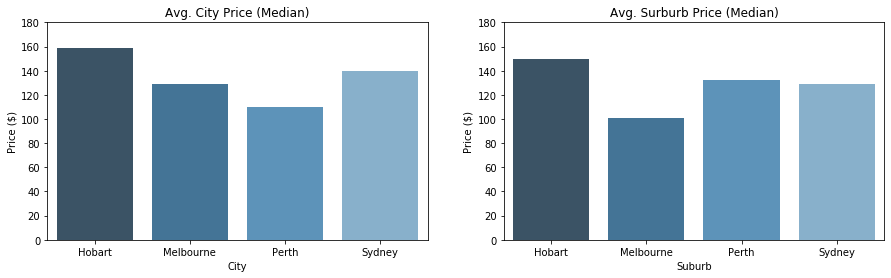

In [13]:
city_avg = comb_cbd.groupby('state_city')['price'].median().sort_values().sort_index()
not_city_avg = comb_not_cbd.groupby('state_city')['price'].median().sort_values().sort_index()

avg_df = [city_avg,not_city_avg]
title = ['Avg. City Price (Median)','Avg. Surburb Price (Median)']
x_label = ['City','Suburb']
    
fig, ax = plt.subplots(1,2,figsize=[15,4])

for i, a in enumerate(avg_df):
    axes=ax[i]
    sns.barplot(x=a.index,y=a.values,palette='Blues_d',ax=axes)
    axes.title.set_text(title[i])
    axes.set_xlabel(x_label[i])
    axes.set_ylabel('Price ($)')
    axes.set_ylim([0,180])
    
plt.savefig('5.png')

In [14]:
clean_property(comb_df,'property_type')

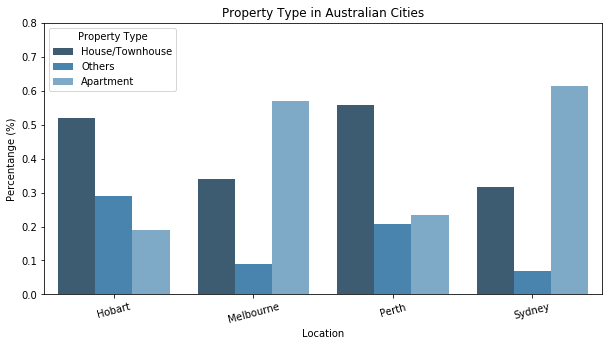

In [15]:
property_comb = comb_df.groupby(['state_city'])['property_type'].value_counts(normalize=True).rename('pct').reset_index()

plt.figure(figsize=[10,5])
sns.barplot(data=property_comb,x='state_city',y='pct',hue='property_type',palette='Blues_d')
plt.xticks(rotation=15)
plt.xlabel('Location')
plt.ylabel('Percentange (%)')
plt.title('Property Type in Australian Cities')
plt.legend(loc='upper left').set_title('Property Type')
plt.ylim([0,0.8])
plt.savefig('6.png');